### 多项式函数拟合

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import gluon, nd, autograd
from mxnet.gluon import loss as gloss, nn, data as gdata

#### 生成数据集

##### 使用三阶多项式生成标签，y = 1.2x-3.4x^2+5.6^3+5+噪声，噪声服从标准差为0.1的正态分布，训练数据集和样本数据集都为100

In [4]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = nd.random.normal(shape=(n_train+n_test, 1))
ploy_features = nd.concat(features, nd.power(features, 2),
                         nd.power(features, 3))
labels = (true_w[0]*ploy_features[:, 0]+true_w[1]*ploy_features[:, 1]+true_w[2]*ploy_features[:, 2]+true_b)
labels += nd.random.normal(scale=0.1, shape=labels.shape)

##### 查看生成的数据集的前两个样本

In [6]:
features[:2], ploy_features[:2, :], labels[:2]

(
 [[-0.38509098]
  [-0.98780406]]
 <NDArray 2x1 @cpu(0)>,
 
 [[-0.38509098  0.14829506 -0.05710709]
  [-0.98780406  0.9757568  -0.9638566 ]]
 <NDArray 2x3 @cpu(0)>,
 
 [ 3.646205 -4.962129]
 <NDArray 2 @cpu(0)>)

##### 定义、训练和预测模型

##### 定义作图函数semilogy,其中y轴使用对数尺度

In [7]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
            legend=None,figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

In [15]:
num_epochs, loss = 100, gloss.L2Loss()
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    batch_size = min(10, train_labels.shape[0])
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels),
                                 batch_size, shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':0.01})
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs+1), train_ls, 'epochs', 'loss', 
            range(1, num_epochs+1), test_ls, ['train', 'test'])
    print('weight:', net[0].weight.data().asnumpy(),
         '\nbias:', net[0].bias.data().asnumpy())
    

##### 三阶多项式拟合（正常）

final epoch: train loss 0.006264451 test loss 0.0067635123
weight: [[ 1.277866 -3.379744  5.580858]] 
bias: [4.9587755]


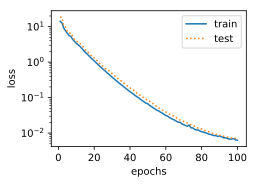

In [16]:
fit_and_plot(ploy_features[:n_train, :], ploy_features[n_train:, :], labels[:n_train], labels[n_train:])

##### 线性函数拟合（欠拟合）

final epoch: train loss 86.64539 test loss 76.88834
weight: [[18.33639]] 
bias: [1.4481193]


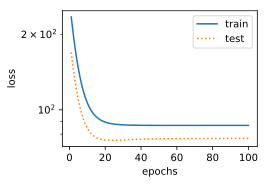

In [19]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

##### 训练样本不足（过拟合）

final epoch: train loss 4.6459084 test loss 103.33242
weight: [[ 0.7268148 -1.2668959  1.4026184]] 
bias: [0.41122365]


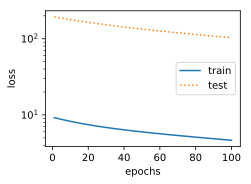

In [20]:
fit_and_plot(ploy_features[:2, :], ploy_features[n_train:, :], labels[:2], labels[n_train:])